In [5]:
event_id = {
    'f_fixation': 1,
    'f_target': 2,
    'f_click': 3,
    's_fix': 4,
    's_target': 5,
    '!_fix': 7,
    '!_target': 8,
    '!_click': 9,
}

In [8]:
import os
from pathlib import Path
import glob
import mne
import matplotlib.pyplot as plt

# ---- User settings ----
folder_path = r'C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF'   # folder containing .bdf files                          
montage_name = 'biosemi64'

# Your event_id mapping
event_id = {
    'f_fixation': 1,
    'f_target': 2,
    'f_click': 3,
    's_fix': 4,
    's_target': 5,
    '!_fix': 7,
    '!_target': 8,
    '!_click': 9,
}

# ---- Setup ----
mne.set_log_level('INFO')
folder = Path(folder_path)
outdir = folder / 'outputs'
outdir.mkdir(parents=True, exist_ok=True)

bdf_files = sorted(glob.glob(str(folder / "*.bdf")))
if not bdf_files:
    raise FileNotFoundError(f"No .bdf files found in: {folder}")

print(f"Found {len(bdf_files)} BDF file(s) in {folder}")

for i, file_path in enumerate(bdf_files, start=1):
    file_path = Path(file_path)
    id_num = str(i).zfill(2)
    base_tag = f"{file_path.stem}__{id_num}"   # more informative filenames

    print(f"\n=== Processing {file_path.name} ({i}/{len(bdf_files)}) ===")

    # Load data
    raw = mne.io.read_raw_bdf(str(file_path), preload=True)

    # Set channel types for non-EEG channels
    misc_chs = [ch for ch in raw.ch_names if ch in ['Erg1', 'Erg2'] or ('EXG' in ch)]
    if misc_chs:
        raw.set_channel_types({ch: 'misc' for ch in misc_chs})

    # Set montage, ignore missing positions
    raw.set_montage(mne.channels.make_standard_montage(montage_name), on_missing='ignore')

    # ----- PSD -----
    try:
        psd = raw.compute_psd(fmax=fmax_psd)
        fig_psd = psd.plot(show=False)
        # handle case where MNE returns a list of figs (rare but safe guard)
        if isinstance(fig_psd, list):
            for k, f in enumerate(fig_psd, start=1):
                out_psd = outdir / f"psd_plot_{base_tag}_{k}.png"
                f.savefig(out_psd, dpi=150, bbox_inches='tight')
                print(f"Saved PSD figure: {out_psd}")
                plt.close(f)
        else:
            out_psd = outdir / f"psd_plot_{base_tag}.png"
            fig_psd.savefig(out_psd, dpi=150, bbox_inches='tight')
            print(f"Saved PSD figure: {out_psd}")
            plt.close(fig_psd)
    except Exception as e:
        print(f"[WARN] PSD plotting failed for {file_path.name}: {e}")

    # ----- Events -----
    try:
        events = mne.find_events(
            raw,
            stim_channel=stim_channel,
            shortest_event=0.05,          # adjust if your triggers are very brief
            initial_event=True            # helpful for some BioSemi files
        )
        if events.size == 0:
            print("[INFO] No events detected—skipping events plot.")
        else:
            # Log a quick summary of event counts
            import numpy as np
            unique, counts = np.unique(events[:, 2], return_counts=True)
            summary = dict(zip(unique.tolist(), counts.tolist()))
            print(f"Event counts by code: {summary}")

            # Only include event codes present in the file (avoids legend clutter)
            present_ids = {k: v for k, v in event_id.items() if v in summary}
            if not present_ids:
                print("[INFO] None of the event_id codes were found in this file; plotting without event_id.")
                fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], show=False)
            else:
                fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)

            out_events = outdir / f"events_plot_{base_tag}.png"
            fig_events.savefig(out_events, dpi=150, bbox_inches='tight')
            print(f"Saved events figure: {out_events}")
            plt.close(fig_events)
    except Exception as e:
        print(f"[WARN] Event detection/plotting failed for {file_path.name}: {e}")

# Ensure all figures are closed
plt.close('all')
print("\nAll files processed. Check the 'outputs' folder for figures.")


Found 6 BDF file(s) in C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF

=== Processing FP_03.bdf (1/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\FP_03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3161087  =      0.000 ...  3086.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_FP_03__01.png
2392 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9 65536]
Event counts by code: {1: 360, 2: 357, 3: 360, 4: 360, 5: 354, 6: 360, 7: 80, 8: 80, 9: 80, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_FP_03__01.png

=== Processing Foreperiod_Jmlah.bdf (2/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\Foreperiod_Jmlah.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2910207  =      0.000 ...  2841.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_Foreperiod_Jmlah__02.png
2357 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9 65536]
Event counts by code: {1: 360, 2: 344, 3: 360, 4: 360, 5: 338, 6: 360, 7: 80, 8: 74, 9: 80, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_Foreperiod_Jmlah__02.png

=== Processing Foreperiod_Sub2.bdf (3/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\Foreperiod_Sub2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2726911  =      0.000 ...  2662.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_Foreperiod_Sub2__03.png
2389 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9 65536]
Event counts by code: {1: 360, 2: 357, 3: 360, 4: 360, 5: 351, 6: 360, 7: 80, 8: 80, 9: 80, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_Foreperiod_Sub2__03.png

=== Processing Sub_05.bdf (4/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\Sub_05.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2605055  =      0.000 ...  2543.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_Sub_05__04.png
2390 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9 65536]
Event counts by code: {1: 360, 2: 353, 3: 360, 4: 360, 5: 356, 6: 360, 7: 80, 8: 80, 9: 80, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_Sub_05__04.png

=== Processing Sub_06.bdf (5/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\Sub_06.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2932735  =      0.000 ...  2863.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_Sub_06__05.png
2369 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9 65536]
Event counts by code: {1: 360, 2: 352, 3: 360, 4: 360, 5: 337, 6: 360, 7: 80, 8: 79, 9: 80, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_Sub_06__05.png

=== Processing sub-01-foreperiod-12-3.bdf (6/6) ===
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\sub-01-foreperiod-12-3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3034111  =      0.000 ...  2962.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:48: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in misc_chs})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Saved PSD figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\psd_plot_sub-01-foreperiod-12-3__06.png
2391 events found on stim channel Status
Event IDs: [    1     2     3     4     5     7     8     9 65536]
Event counts by code: {1: 373, 2: 371, 3: 373, 4: 696, 5: 343, 7: 79, 8: 76, 9: 79, 65536: 1}


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\471248640.py:95: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=present_ids, show=False)


Saved events figure: C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\outputs\events_plot_sub-01-foreperiod-12-3__06.png

All files processed. Check the 'outputs' folder for figures.


In [6]:
import mne
import matplotlib.pyplot as plt
import os
import glob

# Variables
folder_path = r'C:\Users\bhdib\OneDrive\Desktop\PSD'  # Folder with BDF files
task = 'ForePeriod'

# Get all .bdf files in the folder
bdf_files = glob.glob(os.path.join(folder_path, "*.bdf"))

# Loop through each BDF file
for i, file_path in enumerate(bdf_files, start=1):
    id_num = str(i).zfill(2)  # 01, 02, 03...

    print(f"Processing {file_path}...")

    # Load data
    raw = mne.io.read_raw_bdf(file_path, preload=True)

    # Set channel types for non-EEG channels
    raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
    raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})

    # Set montage, ignoring channels without positions
    raw.set_montage(mne.channels.make_standard_montage('biosemi64'), on_missing='ignore')

    # PSD plot
    psd = raw.compute_psd(fmax=100)
    fig_psd = psd.plot(show=False)
    fig_psd.savefig(os.path.join(folder_path, f"psd_plot_{id_num}.png"))
    plt.close(fig_psd)

    # Event detection
    events = mne.find_events(raw, stim_channel="Status", shortest_event=0.05)

    # ⚠️ Define event_id (otherwise you'll get a NameError).
    # If you don’t know them yet, just plot events without event_id
    fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], show=False)
    fig_events.savefig(os.path.join(folder_path, f"events_plot_{id_num}.png"))
    plt.close(fig_events)

print("Finished processing all BDF files.")


Processing C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf...
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2726911  =      0.000 ...  2662.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:23: RuntimeWarning: The unit for channel(s) Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:24: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2388 events found on stim channel Status
Event IDs: [1 2 3 4 5 6 7 8 9]
Processing C:\Users\bhdib\OneDrive\Desktop\PSD\sub-01-foreperiod-12-3.bdf...
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\PSD\sub-01-foreperiod-12-3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3034111  =      0.000 ...  2962.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:23: RuntimeWarning: The unit for channel(s) Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:24: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2390 events found on stim channel Status
Event IDs: [1 2 3 4 5 7 8 9]
Processing C:\Users\bhdib\OneDrive\Desktop\PSD\testdata.bdf...
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\PSD\testdata.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2567167  =      0.000 ...  2506.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:23: RuntimeWarning: The unit for channel(s) Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\4248247284.py:24: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2394 events found on stim channel Status
Event IDs: [1 2 3 4 5 6 7 8 9]
Finished processing all BDF files.


Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2726911  =      0.000 ...  2662.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2888330986.py:13: RuntimeWarning: The unit for channel(s) Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2888330986.py:14: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2388 events found on stim channel Status
Event IDs: [1 2 3 4 5 6 7 8 9]


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2888330986.py:28: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)


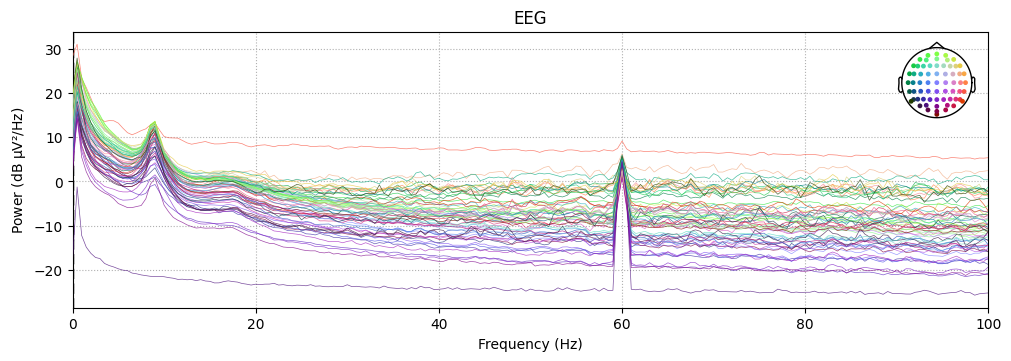

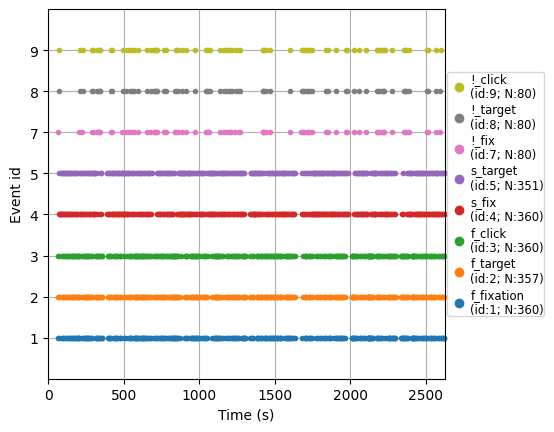

In [2]:
import mne
import matplotlib.pyplot as plt

# Variables
id_num = '01'
task = 'ForePeriod'
file_path = r'C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf'

# Load data
raw = mne.io.read_raw_bdf(file_path, preload=True)

# Set channel types for non-EEG channels
raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})

# Set montage, ignoring channels without positions
raw.set_montage(mne.channels.make_standard_montage('biosemi64'), on_missing='ignore')

# PSD plot
psd = raw.compute_psd(fmax=100)
fig_psd = psd.plot(show=False)
fig_psd.savefig(f"psd_plot_{id_num}.png")

# Event detection
events = mne.find_events(raw, stim_channel="Status", shortest_event=0.05)

# Plot events with event_id
fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
fig_events.savefig(f"events_plot_{id_num}.png")

plt.show()


Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2726911  =      0.000 ...  2662.999 secs...


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:14: RuntimeWarning: The unit for channel(s) Erg1, Erg2 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:15: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})


Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2388 events found on stim channel Status
Event IDs: [1 2 3 4 5 6 7 8 9]


C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:28: RuntimeWarning: event 6 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:33: RuntimeWarning: event 3 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:33: RuntimeWarning: event 4 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:33: RuntimeWarning: event 5 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
C:\Users\bhdib\AppData\Local\Temp\ipykernel_26052\2249362071.py:33: RuntimeWarning: 

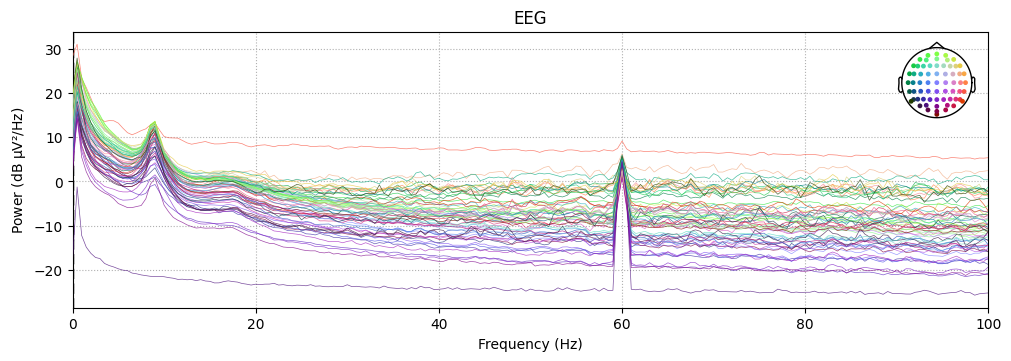

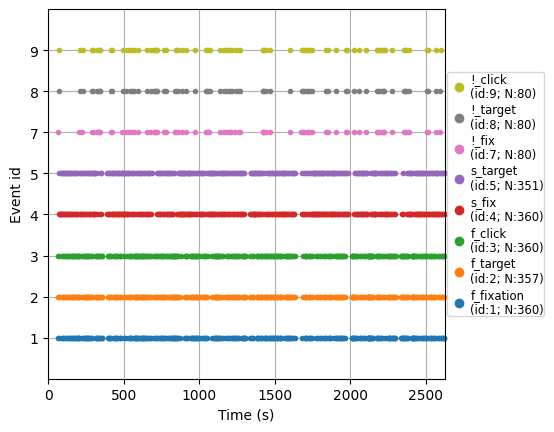

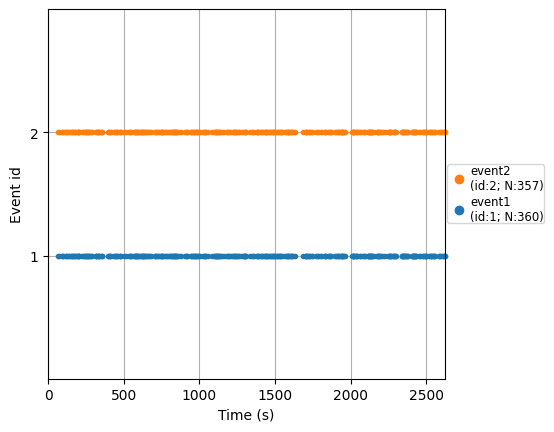

In [3]:
import mne
import matplotlib.pyplot as plt

# Variables
id_num = '01'
task = 'ForePeriod'
file_path = r'C:\Users\bhdib\OneDrive\Desktop\PSD\Foreperiod_Sub2.bdf'

# Load data
raw = mne.io.read_raw_bdf(file_path, preload=True)


# Set channel types for non-EEG channels
raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})

# Set montage, ignoring channels without positions
raw.set_montage(mne.channels.make_standard_montage('biosemi64'), on_missing='ignore')

# PSD plot
psd = raw.compute_psd(fmax=100)
fig_psd = psd.plot(show=False)
fig_psd.savefig(f"psd_plot_{id_num}.png")

events = mne.find_events(raw, stim_channel="Status", shortest_event=0.05)

# Event detection
fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
fig_events.savefig("events_plot.png")


event_id = {'event1': 1, 'event2': 2}  # Customize based on your needs
fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, show=False)
fig_events.savefig(f"events_plot_{id_num}.png")

plt.show()

In [4]:
import numpy as np

print(np.unique(events[:, 2])) 

[1 2 3 4 5 6 7 8 9]
